In [2]:
# import relevant packages

%matplotlib inline

import PIL
import numpy as np
import pandas as pd
import torch
from easyimages import EasyImageList
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score, log_loss
from skorch import *
from skorch.callbacks import (
    Callback,
    CyclicLR,
    Freezer,
    LRScheduler,
    PrintLog,
    scoring,
)
from skorch.utils import *
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import torch.optim as optim
from torch.autograd import Variable


In [59]:
#
import os
import pickle
os.chdir('/Users/lundr/DSRCompTwo')

# Dataframe
path_df = "Pickles/df.pickle"
with open(path_df, 'rb') as data:
    df = pickle.load(data)

# features_train
path_features_train = "Pickles/features_train.pickle"
with open(path_features_train, 'rb') as data:
    features_train = pickle.load(data)

# labels_train
path_labels_train = "Pickles/labels_train.pickle"
with open(path_labels_train, 'rb') as data:
    labels_train = pickle.load(data)

# features_test
path_features_test = "Pickles/features_test.pickle"
with open(path_features_test, 'rb') as data:
    features_test = pickle.load(data)

# labels_test
path_labels_test = "Pickles/labels_test.pickle"
with open(path_labels_test, 'rb') as data:
    labels_test = pickle.load(data)

In [6]:
import os
import pickle
os.chdir('/Users/lundr/DSRCompTwo')

In [12]:
labels_train

176     1.0
384     0.0
856     0.0
589     0.0
674     0.0
       ... 
986     1.0
133     0.0
361     1.0
1364    0.0
451     1.0
Name: Category, Length: 1228, dtype: float64

In [60]:
#cpnvert to tensors
features_train=torch.tensor(features_train)
labels_train=torch.tensor(np.array([labels_train]).reshape(1228,1))
features_test=torch.tensor(features_test)
labels_test=torch.tensor(np.array([labels_test]).reshape(217,1))

#DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [45]:
from torch import nn
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Inputs to hidden layer linear transformation
        self.hidden = nn.Linear(300, 32)
        # Output layer, 10 units - one for each digit
        self.output = nn.Linear(32, 2)
        
        # Define sigmoid activation and softmax output 
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        
        #self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x):
        # Pass the input tensor through each of our operations
        x = self.hidden(x)
        x = self.relu(x)
        x = self.output(x)
        x = self.sigmoid(x)
        

In [22]:
class BoWClassifier(nn.Module):  # inheriting from nn.Module!

    def __init__(self,num_labels, vocab_size):
        # calls the init function of nn.Module.  Dont get confused by syntax,
        # just always do it in an nn.Module
        super(BoWClassifier, self).__init__()
        
        self.layer1=nn.Sequential(
            nn.Linear(300,32),
            nn.ReLU() 
        )
        
        self.layer2=nn.Sequential(
            nn.Linear(32,1),
            nn.Sigmoid() 
        )
#
    def forward(self, bow_vec):
        # Pass the input through the linear layer,
        # then pass that through log_softmax.
        # Many non-linearities and other functions are in torch.nn.functional
        out = self.layer1(bow_vec)
        out = self.layer2(out)
        return out


#def make_bow_vector(sentence, word_to_ix):
 #   vec = torch.zeros(len(word_to_ix))
  #  for word in sentence:
   #     vec[word_to_ix[word]] += 1
    #return vec.view(1, -1)


#def make_target(label, label_to_ix):
#    return torch.LongTensor([label_to_ix[label]])





In [23]:
NUM_LABELS=1
VOCAB_SIZE=300
model = BoWClassifier(1,300)
model

BoWClassifier(
  (layer1): Sequential(
    (0): Linear(in_features=300, out_features=32, bias=True)
    (1): ReLU()
  )
  (layer2): Sequential(
    (0): Linear(in_features=32, out_features=1, bias=True)
    (1): Sigmoid()
  )
)

In [144]:


# one of ['ASGD','Adadelta', 'Adagrad','Adam', 'Adamax','LBFGS', 'RMSprop','Rprop','SGD',SparseAdam']
parameters = model.parameters()
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCELoss()

#model.to(DEVICE)

In [58]:
def process_train_batch(batch):
    X, y = batch
    return X.to(DEVICE), y.to(DEVICE)


def process_eval_batch(batch):
    X, y = batch
    X = X.to(DEVICE)
    y = y.to(DEVICE).detach().cpu().numpy()
    return X, y


def evaluate_model(model, test_loader, print_info=False):
    with torch.no_grad():
        model.eval()
        collect_results = []
        collect_target = []
        for batch in test_loader:
            X, y = process_eval_batch(batch)
            pred = model(X)
            collect_results.append(
                F.sigmoid(pred, dim=1).detach().cpu().numpy())
            collect_target.append(y)

        preds_proba = np.concatenate(collect_results)
        preds = preds_proba.argmax(axis=1)

        targets = np.concatenate(collect_target)

        ll = log_loss(targets, preds_proba)
        acc = accuracy_score(targets, preds)
        if print_info:
            print("test log-loss: {}".format(ll))
            print("overall accuracy:  {}".format(ac))
            #print(classification_report(targets, preds))
        model.train()
        return ll, acc


In [145]:
DEVICE='cpu'

In [146]:
X=features_train
Y=labels_train
N_EPOCHS = 50
loss_history = []
BATCH_SIZE = 100

net=BoWClassifier(1,300)
net = net.double() 

for epoch in range(N_EPOCHS):
    print("training epoch {}".format(epoch))
    for xsample,ysample in zip(X, Y):
        optimizer.zero_grad() 
        # zero the gradients
        # batch preparation
        
        x = xsample
        y = ysample.squeeze()

        #x = torch.Tensor(xsample).unsqueeze(0) # tensor([[0.8745, 0.5205]]) torch.Size([1, 2])
        #y = torch.Tensor([ysample]).unsqueeze(0) # tensor([[1.]]) torch.Size([1, 1])
        x = x.to(DEVICE)
        y = y.to(DEVICE)

#         What will this do once uncommented?
#         if True:
#             ix = np.random.randint(0, size=(16,), high=len(X))
#             x = torch.tensor((X[ix, :])).float()
#             y = torch.tensor(torch.Tensor(Y[ix]).reshape(-1,1)).float()
#             x = x.to(DEVICE)
#             y = y.to(DEVICE)


        # forward pass
        out =  net(x) # prediction, y_hat, 

        # loss calculation
        loss = criterion(out, y)
        # calculating gradients
        loss.backward()

        # changing the weights by specified(in the optimizer init) learning rate
        optimizer.step()

        #append calculated loss to the history
        loss  = loss.detach().cpu().numpy()
        loss_history.append(loss)   
        

training epoch 0
training epoch 1
training epoch 2
training epoch 3
training epoch 4
training epoch 5
training epoch 6
training epoch 7
training epoch 8
training epoch 9
training epoch 10
training epoch 11
training epoch 12
training epoch 13
training epoch 14
training epoch 15
training epoch 16
training epoch 17
training epoch 18
training epoch 19
training epoch 20
training epoch 21
training epoch 22
training epoch 23
training epoch 24
training epoch 25
training epoch 26
training epoch 27
training epoch 28
training epoch 29
training epoch 30
training epoch 31
training epoch 32
training epoch 33
training epoch 34
training epoch 35
training epoch 36
training epoch 37
training epoch 38
training epoch 39
training epoch 40
training epoch 41
training epoch 42
training epoch 43
training epoch 44
training epoch 45
training epoch 46
training epoch 47
training epoch 48
training epoch 49


In [32]:
type(X[0])

torch.Tensor

In [147]:
preds=[]
actual=[]
logprob = []
for instance, label in zip(features_test, labels_test):
    bow_vec = torch.tensor(instance)
    logprobs = net(bow_vec)
    #print(logprobs)
    pred=1 if logprobs>0.5 else 0
    #print('prediction: {}'.format([pred]))
    #print('actual: {}'.format(label))
    preds.append(pred)
    actual.append(label)
    logprob.append(logprobs)


C:\Users\lundr\AppData\Local\Continuum\anaconda3\envs\dl\lib\site-packages\ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """


In [148]:
preds=torch.tensor(preds, dtype=torch.float64)
actual=torch.tensor(actual,dtype=torch.float64)
#Accuracy    
#value_when_true if condition else value_when_false
correct=[]
for i in range(len(preds)):
    if preds[i] == labels_test.reshape(217,)[i]:
        correct.append(1)
    else:
        correct.append(0)
correct =sum(correct)
print("Accuracy: {:.3f}".format(correct/len(labels_test)))

Accuracy: 0.465


Text(0, 0.5, 'loss (CE)')

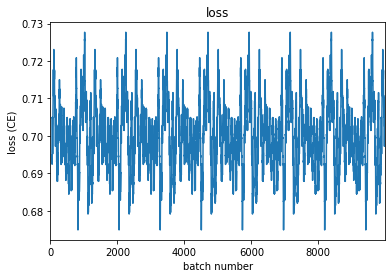

In [150]:
history = pd.DataFrame(loss_history, columns=['loss'])
history.loss[:10000].rolling(50).mean().plot()
plt.title("loss")
plt.xlabel("batch number")
plt.ylabel("loss (CE)")


